# Load the model from file

In [1]:
import tensorflow as tf
from pathlib import Path
from os.path import abspath

ROOT_DIR = Path(abspath('')).parent.parent
MODEL_PATH = ROOT_DIR / "raw" / "checkpoints" / "lstm7_best1"


model = tf.keras.models.load_model(MODEL_PATH)
model.summary()

Metal device set to: Apple M1 Max


2023-02-01 03:17:19.561762: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 75)           7500000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 2056)        9079296   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              2237440   
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                        

# Load the "outer" dataset

In [2]:
OUTER_DS_DIR = ROOT_DIR / "raw" / "outer_dataset"
DATASET_DIR = ROOT_DIR / "raw" / "dataset"
BATCH_SIZE = 256
SEED = 7312

outer_ds = tf.keras.utils.text_dataset_from_directory(
    directory=OUTER_DS_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED
)
outer_ds.class_names

Found 787 files belonging to 2 classes.


['entertainment', 'tech']

# Predicting on outer dataset

In [3]:
result = model.predict(outer_ds)

4/4 [==============================] - 5s 719ms/step


In [4]:
import pandas as pd
import numpy as np

original_dataset_labels = ['business', 'politics', 'sport']
original_ds = tf.keras.utils.text_dataset_from_directory(
    directory=DATASET_DIR,
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    seed=SEED,
)

outer_dataset_labels = outer_ds.class_names
actual_outer_labels = np.concatenate([[outer_dataset_labels[0] if y[0] else outer_dataset_labels[1] for y in y_batch] for x_batch, y_batch in outer_ds], axis=0)
result_df = pd.DataFrame(result, columns=original_dataset_labels)
result_df["Outer label"] = actual_outer_labels
predict_original = model.predict(original_ds)

result_df

Found 1438 files belonging to 3 classes.
6/6 [==============================] - 5s 645ms/step


,business,politics,sport,Outer label
0,0.136583,0.862770,0.000647,tech
1,0.991835,0.007281,0.000884,tech
2,0.969169,0.028583,0.002248,entertainment
3,0.219124,0.780363,0.000513,entertainment
4,0.618157,0.322172,0.059671,entertainment
...,...,...,...,...
782,0.993850,0.005191,0.000959,tech
783,0.001241,0.488546,0.510214,tech
784,0.993040,0.005927,0.001034,entertainment
785,0.000256,0.000923,0.998820,entertainment


In [5]:
model.evaluate(original_ds)

6/6 [==============================] - 5s 663ms/step - loss: 0.1243 - accuracy: 0.9722 - recall: 0.9722 - precision: 0.9729 - auc: 0.9927


[0.12428556382656097,
 0.9721835851669312,
 0.9721835851669312,
 0.9728601574897766,
 0.9926711320877075]

In [6]:
def get_max(softmax: np.ndarray) -> float:
    return np.max(softmax)

def get_predicted_label(softmax: np.ndarray) -> float:
    return original_dataset_labels[np.argmax(softmax)]

# Plot the max(softmax) histogram

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1., 

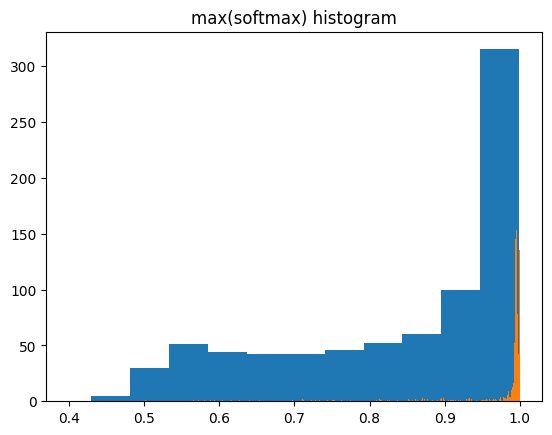

In [7]:
import matplotlib.pyplot as plt

histogram_data = np.apply_along_axis(get_max, 1, result)
original_hist_data = np.apply_along_axis(get_max, 1, predict_original)

plt.title('max(softmax) histogram')
plt.hist(histogram_data, bins='auto')
plt.hist(original_hist_data, bins='auto')
# plt.xlim(0.95, 1)

# Get logits & features

In [8]:
base_input = model.input
base_output = model.layers[-2].output

logits_layer = tf.keras.layers.Dense(3)
logits_outputs = logits_layer(base_output)
logits_model = tf.keras.Model(base_input, logits_outputs, name='logits')

features_model = tf.keras.Model(base_input, base_output, name='features')

logits_model.summary()
features_model.summary()

Model: "logits"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 75)           7500000   
                                                                 
 bidirectional (Bidirectiona  (None, 250, 2056)        9079296   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              2237440   
 nal)                                                            
                                                            

In [9]:
outer_logits = logits_model.predict(outer_ds)
original_logits = logits_model.predict(original_ds)

outer_features = features_model.predict(outer_ds)
original_features = features_model.predict(original_ds)

6/6 [==============================] - 5s 640ms/step


# Plot the max(logits) histogram

(array([  2.,   5.,  20.,  10.,  16.,  24.,  23.,  28.,  39.,  42.,  70.,
         82.,  89., 103.,  84.,  46.,  28.,  13.,  11.,  13.,   8.,   5.,
          6.,   4.,   4.,   5.,   3.,   0.,   0.,   1.,   2.,   1.]),
 array([-0.3550263 , -0.31641853, -0.27781078, -0.23920302, -0.20059526,
        -0.16198748, -0.12337972, -0.08477196, -0.0461642 , -0.00755644,
         0.03105133,  0.06965909,  0.10826685,  0.14687462,  0.18548238,
         0.22409014,  0.26269791,  0.30130568,  0.33991343,  0.3785212 ,
         0.41712895,  0.45573673,  0.49434447,  0.53295225,  0.57156003,
         0.6101678 ,  0.64877552,  0.68738329,  0.72599107,  0.76459885,
         0.80320656,  0.84181434,  0.88042212]),
 <BarContainer object of 32 artists>)

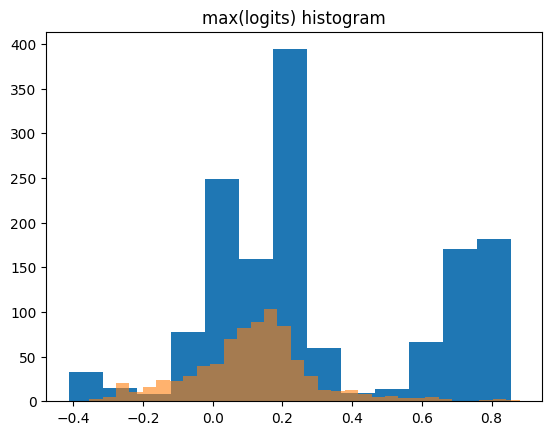

In [10]:
outer_hist_data = np.apply_along_axis(get_max, 1, outer_logits)
idd_hist_data = np.apply_along_axis(get_max, 1, original_logits)

plt.title('max(logits) histogram')
plt.hist(idd_hist_data, bins='auto')
plt.hist(outer_hist_data, bins='auto', alpha=.6)

In [11]:
def get_labels(dataset):
    labels = np.empty((0, 1))
    for x, y in dataset:
        for one_hot in y.numpy():
            labels = np.append(labels, np.argmax(one_hot))

    return labels

In [12]:
original_logits = original_logits[:780, :].reshape((12, -1, 3))
outer_logits = outer_logits[:780, :].reshape((12, -1, 3))
labels = get_labels(original_ds)[:780].reshape((12, -1))

In [13]:
original_features = original_features[:780, :].reshape((12, -1, 256))
outer_features = outer_features[:780, :].reshape((12, -1, 256))

# Mahalanobis distance

In [14]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def confidence(features: np.ndarray,
               means: np.ndarray,
               distance_type: str,
               cov: np.ndarray = None) -> np.ndarray:
    """
    Calculate mahalanobis or euclidean based confidence score for each class.
    Params:
        - features: shape (num_samples, num_features)
        - means: shape (num_classes, num_features)
        - cov: shape (num_features, num_features) or None (if use euclidean distance)

    Returns:
        - confidence: shape (num_samples, num_classes)
    """
    assert distance_type in ("euclidean", "mahalanobis")

    num_samples = features.shape[0]
    num_features = features.shape[1]
    num_classes = means.shape[0]
    if distance_type == "euclidean":
        cov = np.identity(num_features)

    features = features.reshape(num_samples, 1, num_features).repeat(num_classes, axis=1)  # (num_samples, num_classes, num_features)
    means = means.reshape(1, num_classes, num_features).repeat(num_samples, axis=0)  # (num_samples, num_classes, num_features)
    vectors = features - means  # (num_samples, num_classes, num_features)
    cov_inv = np.linalg.inv(cov)
    bef_sqrt = np.matmul(np.matmul(vectors.reshape(num_samples, num_classes, 1, num_features), cov_inv),
                         vectors.reshape(num_samples, num_classes, num_features, 1)).squeeze()
    result = np.sqrt(bef_sqrt)
    result[np.isnan(result)] = 1e12  # solve nan
    return result


def mahalanobis(original, outer, labels, threshold = 1.2, solver="lsqr", distance_type="mahalanobis"):
    false_seen = 0
    for feature_train, feature_test, y_train in zip(original, outer, labels):
        gda = LinearDiscriminantAnalysis(solver=solver, shrinkage=None, store_covariance=True)
        gda.fit(feature_train, y_train)

        y_pred = gda.predict(feature_test)
        gda_result_test = confidence(feature_test, gda.means_, distance_type, gda.covariance_)
        y_pred_score = pd.Series(gda_result_test.min(axis=1))

        y_pred_score[y_pred_score[y_pred_score > threshold].index] = 'unseen'

        false_seen += y_pred_score.value_counts()['unseen'] / y_pred.size
    false_seen /= len(feature_train)

    return false_seen

# Mahalanobis for logits

In [15]:
mahalanobis(original_logits, outer_logits, labels)

0.12236686390532546

# Mahalanobis for features

In [16]:
mahalanobis(original_features, outer_features, labels)

/var/folders/hd/0dm9twls3jd6k1rv5gyhj0c00000gn/T/ipykernel_80051/2886037422.py:31: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(bef_sqrt)
/var/folders/hd/0dm9twls3jd6k1rv5gyhj0c00000gn/T/ipykernel_80051/2886037422.py:31: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(bef_sqrt)
/var/folders/hd/0dm9twls3jd6k1rv5gyhj0c00000gn/T/ipykernel_80051/2886037422.py:31: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(bef_sqrt)
/var/folders/hd/0dm9twls3jd6k1rv5gyhj0c00000gn/T/ipykernel_80051/2886037422.py:31: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(bef_sqrt)
/var/folders/hd/0dm9twls3jd6k1rv5gyhj0c00000gn/T/ipykernel_80051/2886037422.py:31: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(bef_sqrt)
/var/folders/hd/0dm9twls3jd6k1rv5gyhj0c00000gn/T/ipykernel_80051/2886037422.py:31: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(bef_sqrt)
/var/folders/hd/0dm9twls3jd6

0.18461538461538463

# Local Outlier Factor

In [17]:
from sklearn.neighbors import LocalOutlierFactor


def lof(original, outer, labels):
    false_seen = 0
    for feature_train, feature_test, y_train in zip(original, outer, labels):

        lof = LocalOutlierFactor(n_neighbors=1, contamination=0.1, novelty=True, n_jobs=-1)
        lof.fit(feature_train)
        y_pred_lof = lof.predict(feature_test)
        y_pred_score = pd.Series(y_pred_lof)
        y_pred_score[y_pred_score[y_pred_lof==-1].index]='unseen'
        false_seen += y_pred_score.value_counts()['unseen'] / y_pred_lof.size #
    false_seen /= len(feature_train)

    return false_seen

# LOF logits

In [18]:
lof(original_logits, outer_logits, labels)

0.04118343195266271

# LOF features

In [19]:
lof(original_features, outer_features, labels)

0.048047337278106506

# Out of distribution techniques

In [42]:
from sklearn.metrics import auc, roc_curve, precision_recall_curve


def auroc(predictions, labels) -> tuple:
    fpr, tpr, thresholds = roc_curve(labels, predictions, pos_label=1)
    return thresholds, auc(fpr, tpr)

def aupr(predictions, labels) -> tuple:
    precision, recall, thresholds = precision_recall_curve(labels, predictions, pos_label=1)
    return thresholds, auc(recall, precision)

def fpr_at_95_tpr(predictions, labels):
    fpr, tpr, _ = roc_curve(labels, predictions, pos_label=1)

    if all(tpr < 0.95):
        # No threshold allows TPR >= 0.95
        return 0
    elif all(tpr >= 0.95):
        # All thresholds allow TPR >= 0.95, so find the lowest possible FPR
        idxs = [i for i, x in enumerate(tpr) if x >= 0.95]
        return min(map(lambda idx: fpr[idx], idxs))
    else:
        # Linear interp between values to get FPR at TPR == 0.95
        return np.interp(0.95, tpr, fpr)

def detection_error(predictions, labels):
    fpr, tpr, _ = roc_curve(labels, predictions, pos_label=1)

    # Get ratios of positives to negatives
    pos_ratio = sum(np.array(labels) == 1) / len(labels)
    neg_ratio = 1 - pos_ratio

    # Get indexes of all TPR >= 95%
    idxs = [i for i, x in enumerate(tpr) if x >= 0.95]

    # Calc error for a given threshold (i.e. idx)
    # Calc is the (# of negatives * FNR) + (# of positives * FPR)
    _detection_error = lambda idx: neg_ratio * (1 - tpr[idx]) + pos_ratio * fpr[idx]

    # Return the minimum detection error such that TPR >= 0.95
    return min(map(_detection_error, idxs))


In [31]:
labels = np.empty((0, 3))
for x, y in original_ds:
    labels = np.append(labels, y.numpy(), axis=0)

predictions = predict_original[:, 0]
labels = labels[:, 0]

## ROC

In [24]:
thresholds, auc = auroc(predictions, labels)
auc, thresholds

(0.889319024701884,
 array([1.99962902e+00, 9.99629021e-01, 9.99601066e-01, 9.99585688e-01,
        9.99497414e-01, 9.99480426e-01, 9.99450982e-01, 9.99431849e-01,
        9.99426961e-01, 9.99420285e-01, 9.99420047e-01, 9.99373496e-01,
        9.99369919e-01, 9.99337971e-01, 9.99335051e-01, 9.99332666e-01,
        9.99332428e-01, 9.99327779e-01, 9.99325275e-01, 9.99320149e-01,
        9.99317884e-01, 9.99316931e-01, 9.99312758e-01, 9.99299526e-01,
        9.99296308e-01, 9.99290764e-01, 9.99286234e-01, 9.99265015e-01,
        9.99260008e-01, 9.99240518e-01, 9.99232054e-01, 9.99225378e-01,
        9.99218822e-01, 9.99217391e-01, 9.99211490e-01, 9.99209106e-01,
        9.99185264e-01, 9.99175072e-01, 9.99172449e-01, 9.99171615e-01,
        9.99163985e-01, 9.99149799e-01, 9.99148250e-01, 9.99147058e-01,
        9.99120653e-01, 9.99119937e-01, 9.99083042e-01, 9.99079227e-01,
        9.99056399e-01, 9.99034047e-01, 9.99028444e-01, 9.99021053e-01,
        9.99020815e-01, 9.99020576e-01, 9.98

## AuPR
Area under the Precision & Recall curve

In [35]:
thresholds, aupr = aupr(predictions, labels)
aupr, thresholds

(0.9313601281549768,
 array([1.12733345e-04, 1.26271436e-04, 1.36646209e-04, ...,
        9.97769117e-01, 9.97785509e-01, 9.97837007e-01], dtype=float32))

## FPR at 95% TPR
Return the False Positive Ratio when True Positive Ratio is at least 95%

In [41]:
fpr_tpr_95 = fpr_at_95_tpr(predictions, labels)
fpr_tpr_95

0.9461206896551724

## Detection error
Returns missclasification probability when TPR is 95%

In [43]:
error = detection_error(predictions, labels)
error

0.3527227322994806